# Utilising Machine Learning to Detect Phishing Emails
## 1. Introduction
Phishing email attacks are currently one of the most prominent and dangerous forms of cyber attacks presently, victims are lured via deceptive messages that often appear to come from legitimate sources, such as banks and trusted organisations. They often contain urgent requests for personal information such as passwords, credit card details and more. They tend to direct victims over to counterfeit websites which are designed to mimic real ones, in the first quarter of 2024 APWG reported 963,994 unique phishing websites (SOCRadar, 2024) emphasing the significant threat which could easily affect organizations and individuals.

In this project, I will explore the application of various machine learning algorithms to classify emails as either phishing or not phishing, implementing several classifiers such as Random Forest, Naive Bayes, Support Vector Machine, Logistic Regression and Decision Tree. By leveraging these algorithms, I aim to assess their effectiveness in accurately identifying phishing attempts based on features extracted from the email dataset. The project will involve data preprocessing, feature selection, and model evaluation to determine which algorithm provides the best performance in terms of accuracy, precision, and recall.

All models in this project will utilize TfidfVectorizer from the sklearn.feature_extraction.text module. This tool will convert the email documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features, where each row represents an email and each column corresponds to a unique term from the dataset. By setting a maximum of 2000 features, TfidfVectorizer ensures that all models are trained on a consistent representation of the data, facilitating a fair comparison of their performance. This preprocessing step is crucial for enhancing the accuracy and reliability of the models in detecting phishing emails.

Link to data set: https://www.kaggle.com/code/elnahas/phishing-email-detection-using-svm-rfc/input?select=Phishing_Email.csv

<center><img src="https://us.norton.com/content/dam/blogs/images/norton/am/phishing-email-Examples-01.jpg" alt="Phishing Email Example" style="width:800px; height:auto;"></center>

<center> Figure One: Shows an example of a phishing email, pretending to be from LinkedIn (Norton, [No Date]). </center>

## 2. Implementation
### 2.1 Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

### 2.2 Importing the Data Set

In [2]:
emails_df = pd.read_csv("Phishing_Email.csv")
emails_df.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


### 2.3 Data Cleaning and Undersampling

In [5]:
emails_df.isna().sum()
emails_df = emails_df.dropna()

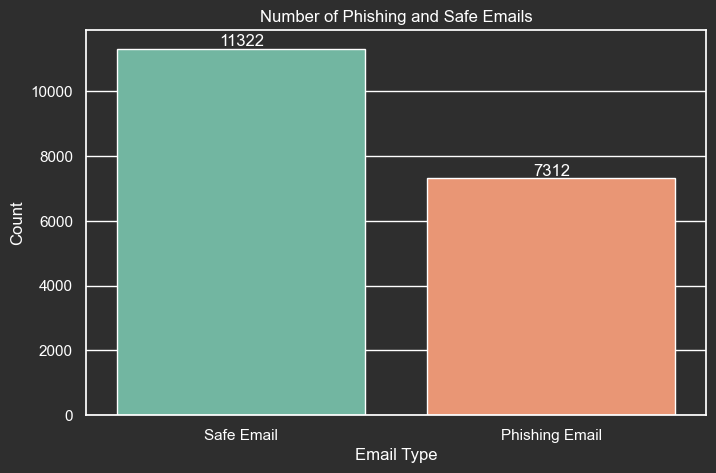

In [33]:
counts = emails_df['Email Type'].value_counts()
email_counts_df = counts.reset_index()
email_counts_df.columns = ['Email Type', 'Count']

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(data=email_counts_df, x='Email Type', y='Count', hue='Email Type', palette='Set2', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.tick_params(axis='both', colors='white')
plt.title('Number of Phishing and Safe Emails', color='white')
plt.xlabel('Email Type', color='white')
plt.ylabel('Count', color='white')
plt.show()

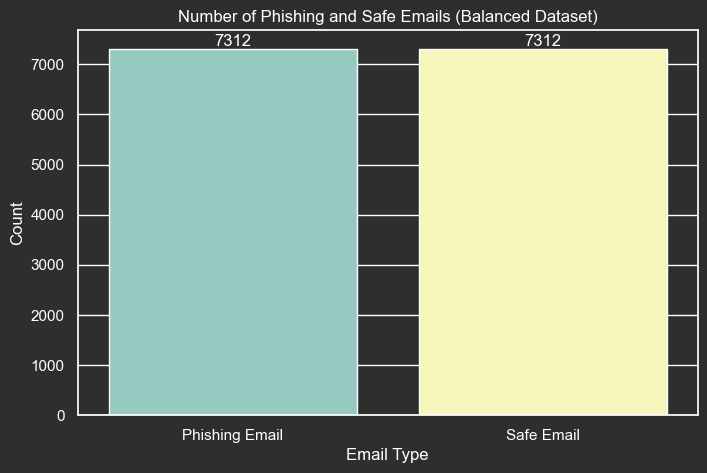

In [31]:
majority_class = emails_df[emails_df['Email Type'] == 'Safe Email']
minority_class = emails_df[emails_df['Email Type'] == 'Phishing Email']

majority_class_undersampled = majority_class.sample(n=len(minority_class), random_state=42)
balanced_emails_df = pd.concat([majority_class_undersampled, minority_class])
balanced_df = balanced_emails_df.sample(frac=1, random_state=42).reset_index(drop=True)

counts = balanced_df['Email Type'].value_counts()
email_counts_df = counts.reset_index()
email_counts_df.columns = ['Email Type', 'Count']

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(data=email_counts_df, x='Email Type', y='Count', hue='Email Type', palette='Set3', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.tick_params(axis='both', colors='white')
plt.title('Number of Phishing and Safe Emails (Balanced Dataset)', color='white')
plt.xlabel('Email Type', color='white')
plt.ylabel('Count', color='white')
plt.show()

### 2.4 Machine Learning

In [35]:
def calculate_confusion_matrix_elements(y_true, y_pred):
    TP = sum((y_true == 1) & (y_pred == 1))
    FP = sum((y_true == 0) & (y_pred == 1))
    TN = sum((y_true == 0) & (y_pred == 0))
    FN = sum((y_true == 1) & (y_pred == 0))
    
    return TP, FP, TN, FN

#### 2.4.1 Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest_classifier(dataframe):
    start_time = time.time()

    X = dataframe["Email Text"].values
    y = dataframe["Email Type"].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train_tfidf, y_train)

    y_prob = clf.predict_proba(X_test_tfidf)[:, 1]
    y_pred = clf.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    TP, FP, TN, FN = calculate_confusion_matrix_elements(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        "accuracy": accuracy,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],  
        "f1-score": report['1']['f1-score'], 
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "roc_auc": roc_auc
    }

    end_time = time.time() 
    elapsed_time = end_time - start_time 
    metrics["elapsed_time"] = elapsed_time 

    return metrics

rf_metrics = train_random_forest_classifier(balanced_df)
print(rf_metrics)

{'accuracy': 0.9594348222424794, 'precision': 0.9756769160165213, 'recall': 0.9444691248334074, 'f1-score': 0.9598194130925508, 'TP': 2126, 'FP': 53, 'TN': 2084, 'FN': 125, 'roc_auc': 0.9922248459427485, 'elapsed_time': 21.21132206916809}


#### 2.4.2 Support Vector Machine (SVM)

In [38]:
from sklearn.svm import SVC 

def train_svm_classifier(dataframe):
    start_time = time.time()
    
    X = dataframe["Email Text"].values
    y = dataframe["Email Type"].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = SVC(kernel='linear', probability=True, random_state=0)  
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_prob = clf.predict_proba(X_test_tfidf)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    TP, FP, TN, FN = calculate_confusion_matrix_elements(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        "accuracy": accuracy,
        "precision": report['1']['precision'], 
        "recall": report['1']['recall'],      
        "f1-score": report['1']['f1-score'],    
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "roc_auc": roc_auc
    }

    end_time = time.time() 
    elapsed_time = end_time - start_time 
    metrics["elapsed_time"] = elapsed_time 

    return metrics

svm_metrics = train_svm_classifier(balanced_df)
print(svm_metrics)

{'accuracy': 0.9642206016408387, 'precision': 0.9780821917808219, 'recall': 0.9515770768547313, 'f1-score': 0.9646476018914659, 'TP': 2142, 'FP': 48, 'TN': 2089, 'FN': 109, 'roc_auc': 0.9937048723938428, 'elapsed_time': 82.3215651512146}


#### 2.4.3 Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree_classifier(dataframe):
    start_time = time.time()
    
    X = dataframe["Email Text"].values
    y = dataframe["Email Type"].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_prob = clf.predict_proba(X_test_tfidf)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    TP, FP, TN, FN = calculate_confusion_matrix_elements(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        "accuracy": accuracy,
        "precision": report['1']['precision'],  
        "recall": report['1']['recall'],    
        "f1-score": report['1']['f1-score'], 
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "roc_auc": roc_auc
    }

    end_time = time.time() 
    elapsed_time = end_time - start_time 
    metrics["elapsed_time"] = elapsed_time 

    return metrics

dt_metrics = train_decision_tree_classifier(balanced_df)
print(dt_metrics)

{'accuracy': 0.898359161349134, 'precision': 0.9119123687813784, 'recall': 0.8876055086628165, 'f1-score': 0.8995947771274201, 'TP': 1998, 'FP': 193, 'TN': 1944, 'FN': 253, 'roc_auc': 0.9034913407174933, 'elapsed_time': 12.569018363952637}


#### 2.4.4 Naive Bayes (NB)

In [40]:
from sklearn.naive_bayes import MultinomialNB

def train_naive_bayes_classifier(dataframe):
    start_time = time.time()
    
    X = dataframe["Email Text"].values
    y = dataframe["Email Type"].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = MultinomialNB()
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_prob = clf.predict_proba(X_test_tfidf)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    TP, FP, TN, FN = calculate_confusion_matrix_elements(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        "accuracy": accuracy,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],  
        "f1-score": report['1']['f1-score'], 
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "roc_auc": roc_auc  
    }

    end_time = time.time() 
    elapsed_time = end_time - start_time 
    metrics["elapsed_time"] = elapsed_time 

    return metrics

nb_metrics = train_naive_bayes_classifier(balanced_df)
print(nb_metrics)

{'accuracy': 0.9567000911577028, 'precision': 0.9652370203160271, 'recall': 0.9498000888494003, 'f1-score': 0.9574563367666816, 'TP': 2138, 'FP': 77, 'TN': 2060, 'FN': 113, 'roc_auc': 0.9910549816470069, 'elapsed_time': 5.577318429946899}


#### 2.4.5 Logistic Regression (LR)

In [41]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression_classifier(dataframe):
    start_time = time.time()

    X = dataframe["Email Text"].values
    y = dataframe["Email Type"].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = LogisticRegression(random_state=0, max_iter=1000)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_prob = clf.predict_proba(X_test_tfidf)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    TP, FP, TN, FN = calculate_confusion_matrix_elements(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        "accuracy": accuracy,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1-score": report['1']['f1-score'],
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "roc_auc": roc_auc
    }

    end_time = time.time()
    elapsed_time = end_time - start_time
    metrics["elapsed_time"] = elapsed_time

    return metrics

lr_metrics = train_logistic_regression_classifier(balanced_df)
print(lr_metrics)

{'accuracy': 0.9628532360984503, 'precision': 0.9754098360655737, 'recall': 0.9515770768547313, 'f1-score': 0.9633460760062964, 'TP': 2142, 'FP': 54, 'TN': 2083, 'FN': 109, 'roc_auc': 0.9935890812942909, 'elapsed_time': 5.721678733825684}


#### 2.4.6 XGBoost

In [43]:
import xgboost as xgb

def train_xgboost_classifier(dataframe):
    start_time = time.time()

    X = dataframe["Email Text"].values
    y = dataframe["Email Type"].values

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=0)

    vectorizer = TfidfVectorizer(max_features=2000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic', random_state=0)
    clf.fit(X_train_tfidf, y_train)

    y_pred = clf.predict(X_test_tfidf)
    y_prob = clf.predict_proba(X_test_tfidf)[:, 1] 

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    TP, FP, TN, FN = calculate_confusion_matrix_elements(y_test, y_pred)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
        "accuracy": accuracy,
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1-score": report['1']['f1-score'],
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "roc_auc": roc_auc
    }

    end_time = time.time()
    elapsed_time = end_time - start_time
    metrics["elapsed_time"] = elapsed_time

    return metrics

xgb_metrics = train_xgboost_classifier(balanced_df)
print(xgb_metrics)

C:\Users\wills\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'accuracy': 0.9626253418413856, 'precision': 0.9806540764624597, 'recall': 0.9458018658374056, 'f1-score': 0.9629127091813658, 'TP': 2129, 'FP': 42, 'TN': 2095, 'FN': 122, 'roc_auc': 0.9937979002521002, 'elapsed_time': 12.922034502029419}


### 2.5 Results 
#### 2.5.1 Accuracy 

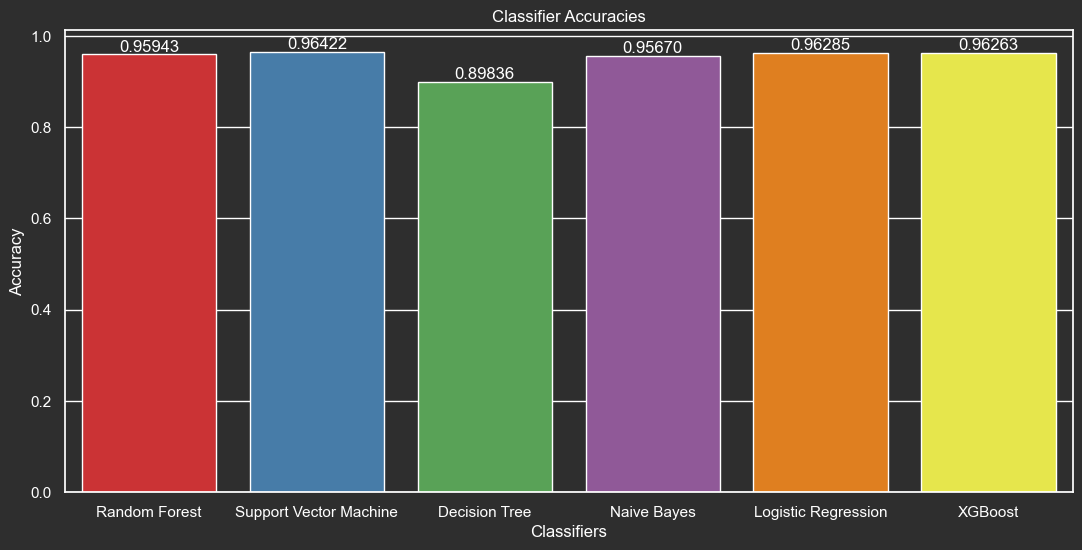

In [97]:
accuracies = {
    "Random Forest": rf_metrics['accuracy'],
    "Support Vector Machine": svm_metrics['accuracy'],
    "Decision Tree": dt_metrics['accuracy'],
    "Naive Bayes": nb_metrics['accuracy'],
    "Logistic Regression": lr_metrics['accuracy'],
    "XGBoost": xgb_metrics['accuracy']
}

accuracies_df = pd.DataFrame(list(accuracies.items()), columns=['Classifier', 'Accuracy'])

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(13, 6))
bar_plot = sns.barplot(data=accuracies_df, x='Classifier', y='Accuracy', hue='Classifier', palette='Set1', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.5f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.title('Classifier Accuracies', color='white')
plt.xlabel('Classifiers', color='white')
plt.ylabel('Accuracy', color='white')
plt.tick_params(axis='both', colors='white')
plt.show()

#### 2.5.2 Precision

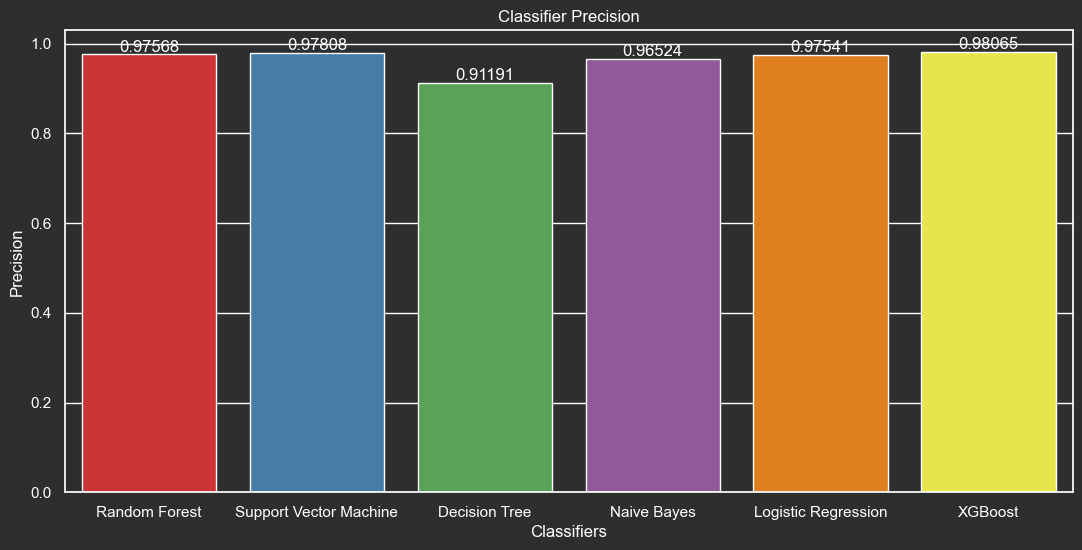

In [95]:
precision_metrics = {
    "Random Forest": rf_metrics['precision'],
    "Support Vector Machine": svm_metrics['precision'],
    "Decision Tree": dt_metrics['precision'],
    "Naive Bayes": nb_metrics['precision'],
    "Logistic Regression": lr_metrics['precision'],
    "XGBoost": xgb_metrics['precision']
}

precision_df = pd.DataFrame(list(precision_metrics.items()), columns=['Classifier', 'Precision'])

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(13, 6))
bar_plot = sns.barplot(data=precision_df, x='Classifier', y='Precision', hue='Classifier', palette='Set1', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.5f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.title('Classifier Precision', color='white')
plt.xlabel('Classifiers', color='white')
plt.ylabel('Precision', color='white')
plt.tick_params(axis='both', colors='white')
plt.show()

#### 2.5.3 Recall

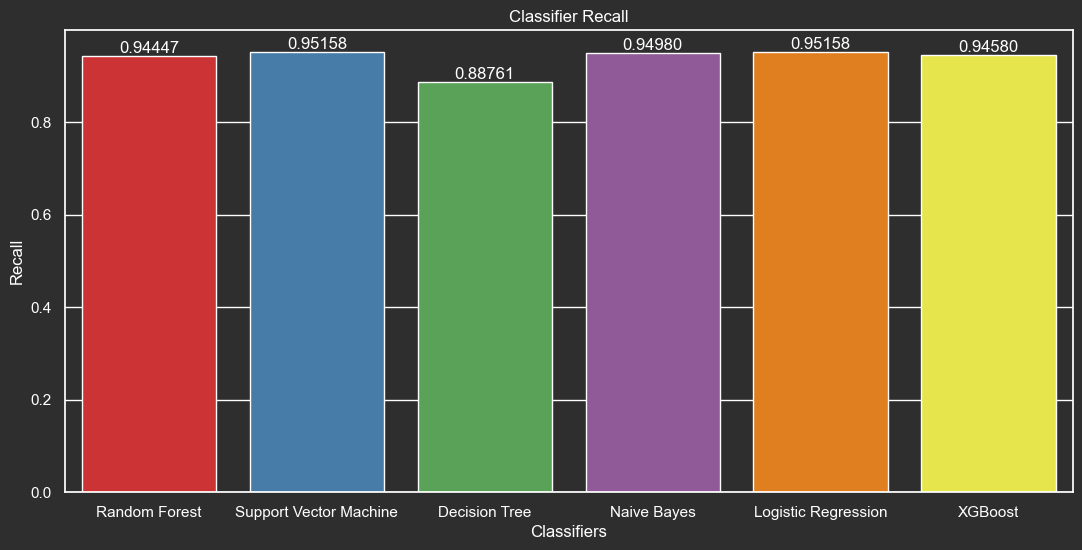

In [93]:
recall_metrics = {
    "Random Forest": rf_metrics['recall'],
    "Support Vector Machine": svm_metrics['recall'],
    "Decision Tree": dt_metrics['recall'],
    "Naive Bayes": nb_metrics['recall'],
    "Logistic Regression": lr_metrics['recall'],
    "XGBoost": xgb_metrics['recall']
}

recall_df = pd.DataFrame(list(recall_metrics.items()), columns=['Classifier', 'Recall'])

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(13, 6))
bar_plot = sns.barplot(data=recall_df, x='Classifier', y='Recall', hue='Classifier', palette='Set1', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.5f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.title('Classifier Recall', color='white')
plt.xlabel('Classifiers', color='white')
plt.ylabel('Recall', color='white')
plt.tick_params(axis='both', colors='white')
plt.show()

#### 2.5.4 F1 Score

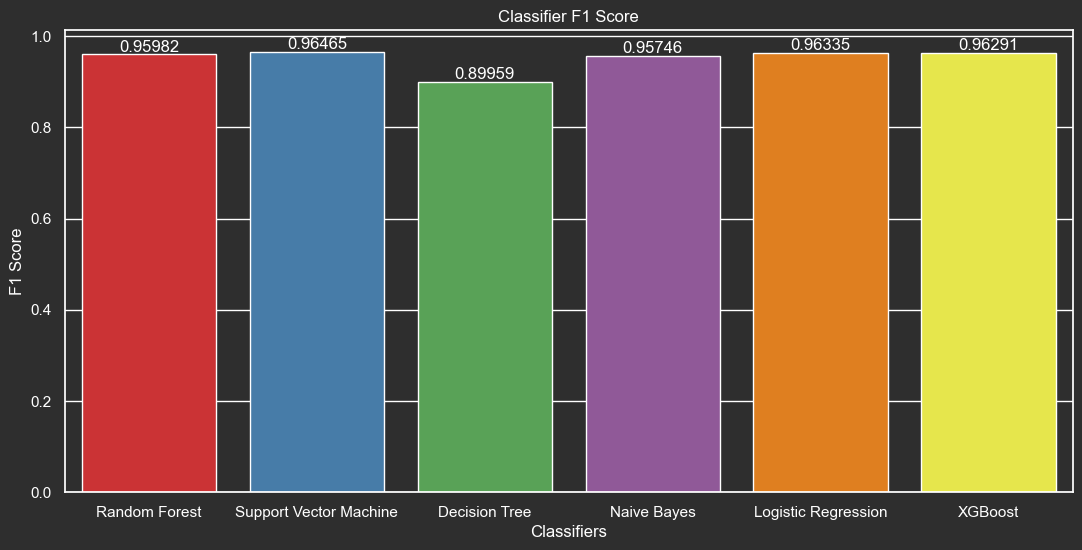

In [91]:
f1_score_metrics = {
    "Random Forest": rf_metrics['f1-score'],
    "Support Vector Machine": svm_metrics['f1-score'],
    "Decision Tree": dt_metrics['f1-score'],
    "Naive Bayes": nb_metrics['f1-score'],
    "Logistic Regression": lr_metrics['f1-score'],
    "XGBoost": xgb_metrics['f1-score']
}

f1_score_df = pd.DataFrame(list(f1_score_metrics.items()), columns=['Classifier', 'F1 Score'])

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(13, 6))
bar_plot = sns.barplot(data=f1_score_df, x='Classifier', y='F1 Score', hue='Classifier', palette='Set1', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.5f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.title('Classifier F1 Score', color='white')
plt.xlabel('Classifiers', color='white')
plt.ylabel('F1 Score', color='white')
plt.tick_params(axis='both', colors='white')
plt.show()

#### 2.5.5 Confusion Matrix

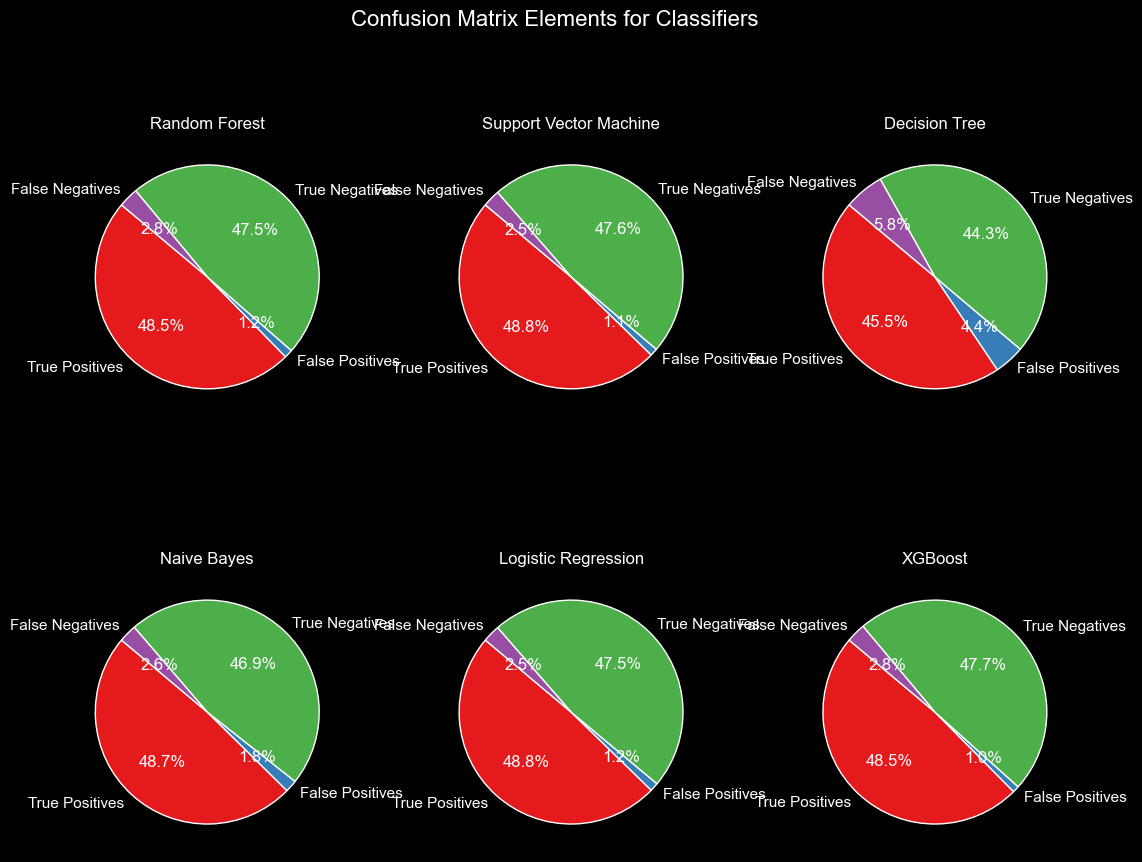

In [89]:
confusion_data = {
    "Random Forest": (rf_metrics['TP'], rf_metrics['FP'], rf_metrics['TN'], rf_metrics['FN']),
    "Support Vector Machine": (svm_metrics['TP'], svm_metrics['FP'], svm_metrics['TN'], svm_metrics['FN']),
    "Decision Tree": (dt_metrics['TP'], dt_metrics['FP'], dt_metrics['TN'], dt_metrics['FN']),
    "Naive Bayes": (nb_metrics['TP'], nb_metrics['FP'], nb_metrics['TN'], nb_metrics['FN']),
    "Logistic Regression": (lr_metrics['TP'], lr_metrics['FP'], lr_metrics['TN'], lr_metrics['FN']),
    "XGBoost": (xgb_metrics['TP'], xgb_metrics['FP'], xgb_metrics['TN'], xgb_metrics['FN'])
}

plt.style.use('dark_background')

fig, axs = plt.subplots(2, 3, figsize=(13, 10))
axs = axs.flatten()

for ax, (classifier, (TP, FP, TN, FN)) in zip(axs, confusion_data.items()):
    labels = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
    values = [TP, FP, TN, FN]
    
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set1.colors)
    ax.set_title(classifier, color='white')

plt.suptitle('Confusion Matrix Elements for Classifiers', color='white', fontsize=16)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

#### 2.5.6 ROC AUC

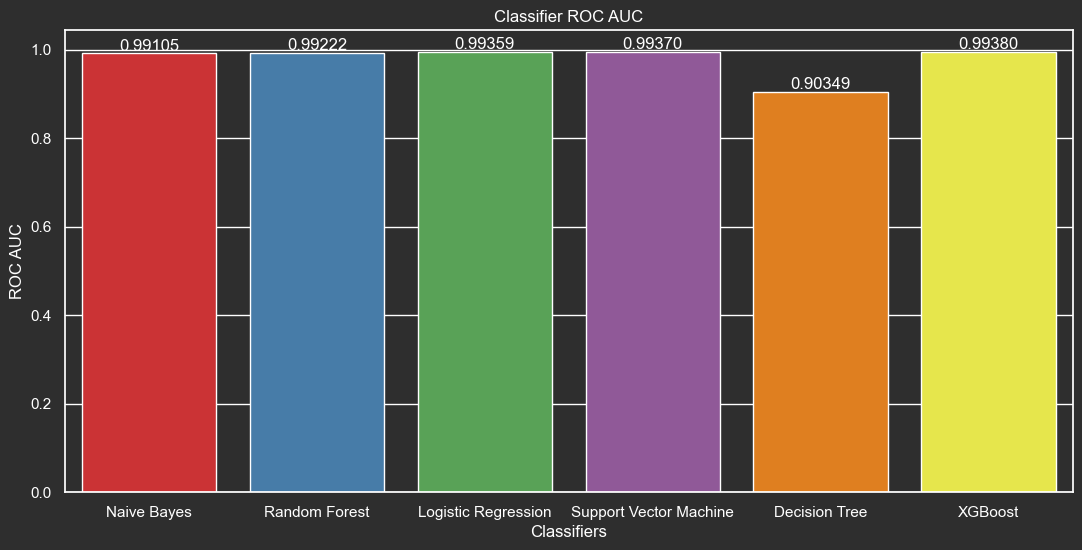

In [87]:
roc_auc_metrics = {
    "Naive Bayes": nb_metrics['roc_auc'],
    "Random Forest": rf_metrics['roc_auc'],
    "Logistic Regression": lr_metrics['roc_auc'],
    "Support Vector Machine": svm_metrics['roc_auc'],
    "Decision Tree": dt_metrics['roc_auc'],
    "XGBoost": xgb_metrics['roc_auc']
}

roc_auc_df = pd.DataFrame(list(roc_auc_metrics.items()), columns=['Classifier', 'ROC AUC'])

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(13, 6))
bar_plot = sns.barplot(data=roc_auc_df, x='Classifier', y='ROC AUC', hue='Classifier', palette='Set1', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.5f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.title('Classifier ROC AUC', color='white')
plt.xlabel('Classifiers', color='white')
plt.ylabel('ROC AUC', color='white')
plt.tick_params(axis='both', colors='white')
plt.show()

#### 2.5.7 Time Taken

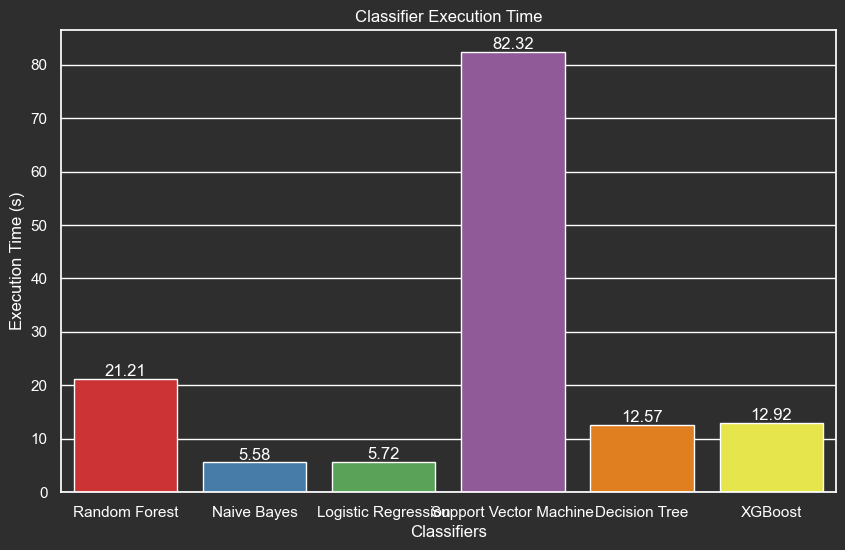

In [85]:
execution_times = {
    "Random Forest": rf_metrics['elapsed_time'],
    "Naive Bayes": nb_metrics['elapsed_time'],
    "Logistic Regression": lr_metrics['elapsed_time'],
    "Support Vector Machine": svm_metrics['elapsed_time'],
    "Decision Tree": dt_metrics['elapsed_time'],
    "XGBoost": xgb_metrics['elapsed_time']
}

time_df = pd.DataFrame(list(execution_times.items()), columns=['Classifier', 'Execution Time (s)'])

sns.set(style="darkgrid", rc={"axes.facecolor": "#2E2E2E", "figure.facecolor": "#2E2E2E", "text.color": "white"})

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=time_df, x='Classifier', y='Execution Time (s)', hue='Classifier', palette='Set1', legend=False)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', color='white', fontsize=12)

plt.title('Classifier Execution Time', color='white')
plt.xlabel('Classifiers', color='white')
plt.ylabel('Execution Time (s)', color='white')
plt.tick_params(axis='both', colors='white')
plt.show()

## 3. Conclusion & Future Work
The results clearly demonstrate the superior performance of XGBoost, SVM, and Logistic Regression in detecting phishing emails. They consistently outperformed Random Forest, Naive Bayes, and Decision Tree across all metrics, including: accuracy, precision, recall, and F1-score. XGBoost, in particular, exhibited exceptional precision, effectively identifying true positive cases. 

The strong performance of these models can be attributed to their ability to capture complex patterns within the email data. XGBoost's ensemble nature, SVM's kernel-based approach, and Logistic Regression's statistical foundation enable them to handle diverse features and make accurate predictions. These findings highlight the potential of these models to significantly enhance phishing email detection systems and mitigate cybersecurity risks.

In conclusion, this project provides a solid foundation for phishing email detection. By leveraging the power of machine learning it's possible to significantly improve the accuracy and efficiency of identifying malicious emails. Future extensions will include incorporating deep learning models, utilising a significantly larger dataset, seperating the features from the dataset into distinct variables (e.g. URL, header, text) to further enhance performance.

By William Shepherd (25/11/2024)

## 4. References


Norton. [No Date]. Phishing email examples. Available at: https://us.norton.com/blog/online-scams/phishing-email-examples (Accessed: [19/11/2024).

SOCRadar. (2024). Top 10 trends in phishing attacks 2024. Available at: https://socradar.io/top-10-trends-in-phishing-attacks-2024/ (Accessed: 19/11/2024).
